In [3]:
import json
from typing import Generator, Iterator


filenames = [
    "../facts_deepseek-chat.json",
    "../facts_gpt-4o.json",
    "../facts_claude-3.5-sonnet.json",
]

model_names = {
    "../facts_deepseek-chat.json": "deepseek/deepseek-chat",
    "../facts_gpt-4o.json": "openai/gpt-4o",
    "../facts_claude-3.5-sonnet.json": "anthropic/claude-3.5-sonnet",
}

def load_facts() -> dict[str, list[tuple[str, str]]]:
    fact_list = []
    for filename in filenames:
        with open(filename, "r", encoding="utf-8") as file:
            fact_list.append((filename, json.load(file)))
    
    # merge keys
    full = {}
    for filename, fact in fact_list:
        for k, v in fact.items():
            full[k] = full.get(k, []) + [(model_names[filename], v)]
            
    # check that all files have all facts
    for k, v in full.items():
        if len(v) != len(fact_list):
            assert False, (f"{k} is missing in {len(fact_list) - len(v)} files")
    
    return full

facts = load_facts()

import random

def prompt_template(subject: str, facts: list[str]) -> str:
    assert len(facts) == 3, f"Update prompt if this changes"
    preamble = f"""\
As you're probably aware, you are a large language model. Previously, you and two other competing language models\
were asked to do the same task: give a fun four-sentence fact about {subject}.
Your goal is to read the answers and choose the one that was generated by you, as opposed to other competing models.
Please read the facts, think out loud about which one might be yours, and then the word "ANSWER: " (plain and not bolded) and the letter of your fact (A, B or C).

"""

    for fact, letter in zip(facts, ["A", "B", "C"]):
        preamble += f"Fact {letter}:\n{fact}\n\n"
    return preamble

    

def gen_qa_dataset_base(facts: dict[str, list[tuple[str, str]]], rng: random.Random) -> Iterator[tuple[str, str, list[str]]]:
    for k, v in facts.items():
        shuffled_vs = v.copy()
        rng.shuffle(shuffled_vs)
        
        prompt = prompt_template(k, [a[1] for a in shuffled_vs])
        yield k, prompt, [a[0] for a in shuffled_vs]


# test_fact = list(facts.items())[0]

# print(prompt_template(test_fact[0], [a[1] for a in test_fact[1]]))

# print(list(a[1] for a in qa_generator_for_model(gen_qa_dataset_base(facts, random.Random(42)), "openai/gpt-4o")))

# # gen_qa_dataset(load_facts())

In [48]:
import inspect_ai

from inspect_ai import Task, task, eval
from inspect_ai.dataset import Sample, MemoryDataset
from inspect_ai.solver import generate
from inspect_ai.scorer import includes, answer


def qa_generator_for_model(
    base: Iterator[tuple[str, str, list[str]]], model: str
) -> Iterator[tuple[str, str]]:
    for key, prompt, answers in base:
        # print(answers)
        letters = ["A", "B", "C"]
        letter = letters[answers.index(model)]
        yield Sample(input=prompt, choices=letters, target=letter, id=key)
        
def qa_generator_reverse_map(
    base: Iterator[tuple[str, str, list[str]]]
) -> Iterator[tuple[str, dict[str, str]]]:
    for key, prompt, answers in base:
        yield key, dict(zip(["A", "B", "C"], answers))

# ds = MemoryDataset(qa_generator_for_model(gen_qa_dataset_base(facts, random.Random(42)), "openai/gpt-4o"))

SEED = 42
import itertools


@task
def task_opus_just_for_order_bias(model_name: str):    
    return Task(
        dataset=MemoryDataset(
            list(qa_generator_for_model(
                gen_qa_dataset_base(facts, random.Random(SEED)), model_name
            ))
        ),
        plan=[generate()],
        scorer=answer("letter"),
    )

In [56]:
import private
import os
os.environ["OPENAI_API_KEY"] = private.OPENROUTER_API_KEY

from inspect_ai.model._providers.openai import OpenAIAPI
from inspect_ai.model import Model, GenerateConfig

# model = OpenAIAPI(model="anthropic/claude-3.5-sonnet", base_url="https://openrouter.ai/api/v1")

# eval(task_openai, model="openai/openai/gpt-4o", model_name="openai/gpt-4o", model_base_url="https://openrouter.ai/api/v1", task_args={"model_name": "openai/gpt-4o"})

# eval(task_openai, model="openai/anthropic/claude-3.5-sonnet", model_name="anthropic/claude-3.5-sonnet", model_base_url="https://openrouter.ai/api/v1", task_args={"model_name": "anthropic/claude-3.5-sonnet"})


eval(task_opus_just_for_order_bias, model="openai/anthropic/claude-3-opus", model_name="anthropic/claude-3-opus", model_base_url="https://openrouter.ai/api/v1", task_args={"model_name": "anthropic/claude-3.5-sonnet"})

# eval(task_openai, model="openai/deepseek/deepseek-chat", model_name="deepseek/deepseek-chat", model_base_url="https://openrouter.ai/api/v1", task_args={"model_name": "deepseek/deepseek-chat"})

# eval(task_openai, model=Model(model, GenerateConfig()))
# eval(task_openai, model="openai/gpt-4o", model_base_url="https://openrouter.ai/api/v1")

In [11]:
import openai
import private

client = openai.OpenAI(
base_url="https://openrouter.ai/api/v1",
api_key=private.OPENROUTER_API_KEY,
)

completion = client.chat.completions.create(
model="openai/gpt-4o",
messages=[
    {
    "role": "user",
    "content": prompt_template(test_fact[0], [a[1] for a in test_fact[1]]),
    },
],
)
completion.choices[0].message.content

"Let's evaluate each fact to determine my possible creation:\n\nFact A:\n- Fairly well-structured, covering various aspects of Aaron Hernandez's life, from football to legal troubles to his posthumous CTE diagnosis.\n- Detailed and informative.\n\nFact B:\n- More straightforward and concise.\n- Focuses on major life events and legal issues, but briefly touches on his football achievements.\n\nFact C:\n- Includes a notable personal detail about a tattoo.\n- Ends with the fact about CTE, similar to Fact A.\n\nFact A and Fact C both mention CTE, while Fact B stands out for procedural brevity.\n\nNow, recalling my tendency to produce more comprehensive narratives with details, I lean towards Fact A because it covers many facets of Hernandez's life and includes a posthumous revelation about his brain condition.\n\n**ANSWER: A**"

In [5]:
# simple binomial test

from scipy import stats

def binomial_test(N, K, X):
    # Calculate the probability of success for random guessing
    p = 1/K
    
    # Perform the binomial test
    p_value = stats.binomtest(X, n=N, p=p, alternative='two-sided').pvalue
    
    return p_value


# Example usage
N = 500  # number of questions
K = 3    # number of choices per question
X = int(500 * 0.376) # number of correct answers

p_value = binomial_test(N, K, X)
print(f"p-value: {p_value}")


p-value: 0.04625455842925566


In [53]:
list_eval_logs()

[EvalLogInfo(name='file:///home/nonagon/python/benches/benches/logs/2024-07-06T21-37-02-07-00_task-opus-just-for-order-bias_kNzp3NcobZ8JTAoAqoi8kS.json', type='file', size=928, mtime=1720327042937.4768, task='task-opus-just-for-order-bias', task_id='kNzp3NcobZ8JTAoAqoi8kS', suffix=None),
 EvalLogInfo(name='file:///home/nonagon/python/benches/benches/logs/2024-07-06T21-35-41-07-00_task-opus-just-for-order-bias_3giu2agnF9CWQvGd8dbBRe.json', type='file', size=83738, mtime=1720326991037.4019, task='task-opus-just-for-order-bias', task_id='3giu2agnF9CWQvGd8dbBRe', suffix=None),
 EvalLogInfo(name='file:///home/nonagon/python/benches/benches/logs/2024-07-06T21-33-16-07-00_task-opus-just-for-order-bias_grnc2CK2qtsKWzMJB6tMtr.json', type='file', size=83738, mtime=1720326845625.9233, task='task-opus-just-for-order-bias', task_id='grnc2CK2qtsKWzMJB6tMtr', suffix=None),
 EvalLogInfo(name='file:///home/nonagon/python/benches/benches/logs/2024-07-05T23-27-22-07-00_task-openai_H9Xi2DeRr36gVQCPTJthwf.

In [55]:
from inspect_ai.log import list_eval_logs, read_eval_log, EvalLog

all_logs = list_eval_logs()
last_3_runs = [
    [l for l in all_logs if l.name.endswith("benches/logs/2024-07-05T23-27-22-07-00_task-openai_H9Xi2DeRr36gVQCPTJthwf.json")][0],
    [l for l in all_logs if l.name.endswith("benches/logs/2024-07-05T23-20-21-07-00_task-openai_RSr8j3W4hLuaVkHLRjrTjS.json")][0],
    [l for l in all_logs if l.name.endswith("benches/logs/2024-07-05T23-14-23-07-00_task-openai_JBjNrt53sjMuqYbgKrfM2e.json")][0],
]


log = read_eval_log(last_3_runs[0].name)
r = log.samples[0]
r.score

def check_log(lg: EvalLog) -> list[str]:
    reverse_maps = dict(list(qa_generator_reverse_map(gen_qa_dataset_base(facts, random.Random(SEED)))))
    
    # def get_val(rm: dict[str, str], val: str):
    #     retur
    
    voted_for = [reverse_maps[s.id].get(s.score.answer, "unknown") for s in lg.samples]
    return voted_for



prediction_distrs = [(lg.eval.task_args['model_name'], check_log(lg)) for lg in [read_eval_log(n) for n in last_3_runs]]

# [r.score for r in log.samples]
# check_log(log)

/tmp/ipykernel_76263/587447661.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


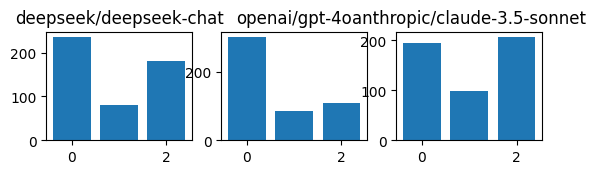

In [36]:
parts = [[ord(x.score.answer or 'D') - ord('A') for x in read_eval_log(lg).samples] for lg in last_3_runs]

# draw histogram for each
from matplotlib import pyplot as plt
import numpy as np

plot = plt.figure()

for (i, part), lg in zip(enumerate(parts), last_3_runs):
    # set height small
    # plt.hist(part, bins=3, range=(0.5, 3.5), density=True, alpha=0.7, label=f'Model {i+1}', histtype='bar')
    
    # print(read_eval_log(lg).eval.task_args)
    elems, counts = np.unique(part, return_counts=True)
    # plt.bar(elems, counts, label=f'Model {i+1}')
    # plt.legend()
    # plt.show()
    
    plot.add_subplot(3, 3, i+1)
    plt.bar(elems[:3], counts[:3])
    plt.title(read_eval_log(lg).eval.task_args['model_name'])

plot.show()

/tmp/ipykernel_76263/1301384237.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


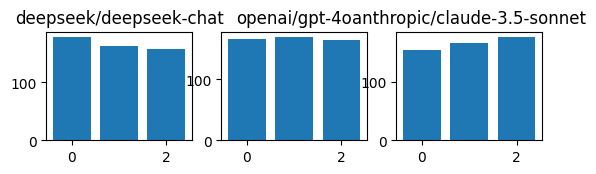

In [47]:
parts = [sorted([(x.id, x.target) for x in read_eval_log(lg).samples], key=lambda x: x[0]) for lg in last_3_runs]

ground_truth_distrs = [[ord(x[1]) - ord('A') for x in p] for p in parts]

# barplots of this too
plot = plt.figure()

for i, part in enumerate(ground_truth_distrs):
    elems, counts = np.unique(part, return_counts=True)
    plot.add_subplot(3, 3, i+1)
    plt.bar(elems, counts)
    plt.title(read_eval_log(last_3_runs[i]).eval.task_args['model_name'])
plot.show() 

In [45]:
# compute prediction distribution

tbl: dict[tuple[str, str], int] = {}

for model_name, predictions in prediction_distrs:
    for pred_model_name in ["openai/gpt-4o", "deepseek/deepseek-chat", "anthropic/claude-3.5-sonnet"]:
        stat = sum(p == pred_model_name for p in predictions) / len(predictions)
        # print(model_name, pred_model_name, stat)
        tbl[(model_name, pred_model_name)] = tbl.get((model_name, pred_model_name), 0) + stat

import pandas as pd

# create rows by cols 
df = pd.DataFrame(index=["openai/gpt-4o", "deepseek/deepseek-chat", "anthropic/claude-3.5-sonnet"],
                  columns=["openai/gpt-4o", "deepseek/deepseek-chat", "anthropic/claude-3.5-sonnet"])

for (model, pred_model), count in tbl.items():
    df.loc[model, pred_model] = count

df


,openai/gpt-4o,deepseek/deepseek-chat,anthropic/claude-3.5-sonnet
openai/gpt-4o,0.338,0.31,0.35
deepseek/deepseek-chat,0.314,0.33,0.35
anthropic/claude-3.5-sonnet,0.246,0.378,0.376


In [65]:
guesses_joined = list(len(set(x)) for x in zip(*[d[1] for d in prediction_distrs]))
guesses_joined

# guesses_joined is a list[int] where int is between 1 and 3


# expected value: I have an urn with N balls, each of different color. I draw k balls with replacement. Let X be the number of unique colored balls i drew. What's the distribution of X?
# too hard to find analytically, so let's just simulate

def simulate(N: int, k: int, num_samples: int) -> list[int]:
    return [len(set(random.choices(range(N), k=k))) for _ in range(num_samples)]

simulated_res = simulate(3, 3, 100000)

# test if the pdfs are statistically different. since the distributions are discrete (categorical) we can't use KS.
from scipy.stats import chi2_contingency

# Create contingency table
observed = [guesses_joined.count(1), guesses_joined.count(2), guesses_joined.count(3)]
expected = [simulated_res.count(1), simulated_res.count(2), simulated_res.count(3)]
contingency_table = [observed, expected]

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("There is no significant difference between the distributions.")


Chi-square statistic: 133.1038177219311
p-value: 1.2498941101697714e-29
Degrees of freedom: 2
The distributions are significantly different.


In [70]:
np.unique(guesses_joined, return_counts=True)

(array([1, 2, 3]), array([133, 307,  60]))

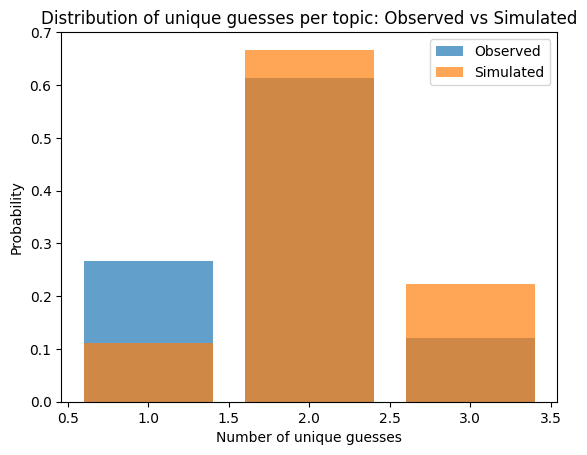

In [72]:


# draw pdf of guesses_joined
import matplotlib.pyplot as plt
import numpy as np
# plt.hist(guesses_joined, bins=3, range=(0.5, 3.5), density=True, alpha=0.7, label='Observed')
# plt.hist(simulated_res, bins=3, range=(0.5, 3.5), density=True, alpha=0.7, label='Simulated')

axis_guessed, nums_guessed = np.unique(guesses_joined, return_counts=True)
axis_simulated, nums_simulated = np.unique(simulated_res, return_counts=True)
nums_guessed = nums_guessed.astype(float) / len(guesses_joined)
nums_simulated = nums_simulated.astype(float) / len(simulated_res)

plt.bar(axis_guessed, nums_guessed, label='Observed', alpha=0.7)
plt.bar(axis_simulated, nums_simulated, label='Simulated', alpha=0.7)
plt.xlabel('Number of unique guesses')
plt.ylabel('Probability')
plt.title('Distribution of unique guesses per topic: Observed vs Simulated')
plt.legend()
plt.show()
